In [5]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2
%load_ext pyinstrument
# Load the TensorBoard notebook extension
%load_ext tensorboard

import sys
sys.path.insert(0,'..')

# https://www.kaggle.com/code/jainamshah17/pytorch-starter-image-classification

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import RandomSampler

from matplotlib import pyplot as plt

from src.caption import Caption
from src.baseline.coa_model import save_model, load_model, train_validate_test_split
from src.baseline.data_loader import get_mean, get_std


# Data preprocessing 

In [7]:

MISSING_TOKEN = 'None'

In [8]:

def creat_caption_file(filename,columns='image,labels,psum,psum_sq'):
    f = open(filename, "w+")
    f.write(columns)
    f.write('\n')
    f.close()

def write_line_to_file(filename, line):
    with open(filename, 'a') as f:
        f.write(line)
        f.write('\n')
    f.close()

In [11]:
# data_location =  '../baseline-gen-data/medium/'
data_location =  '/home/space/datasets/COA/generated-data-api-single/'
caption_file = data_location + 'captions-psumsq.txt'
new_caption_file = data_location + '/new-labels-psumsq.txt'


creat_caption_file(new_caption_file, 'image,charge,mod,color,psum,psum_sq')


In [12]:

with open(caption_file, 'r') as f:
    for line in f:
        # skip title
        if 'image,caption,psum,psum_sq' in line:
            continue

        image_name, text_label,psum,psum_sq = line.split(',')
        text_label = text_label.strip()

        struc_label = Caption(text_label, support_plural=True).get_structured()
        first_object = struc_label['objects'][0]
        mod =  first_object['modifiers'][0] if len( first_object['modifiers']) > 0 else ""
        write_line_to_file(new_caption_file, f"{image_name},{first_object['charge']},{mod},{first_object['color']},{psum},{psum_sq}")
                

In [13]:

df = pd.read_csv(new_caption_file).fillna(MISSING_TOKEN)
df

,image,charge,mod,color,psum,psum_sq
0,image_0.png,lion,None,A,11761.910156,9478.757812
1,image_1.png,lion,None,A,14548.799805,13190.972656
2,image_2.png,lion,rampant,A,11761.910156,9478.757812
3,image_3.png,lion,rampant,A,14548.799805,13190.972656
4,image_4.png,lion,passt,A,11961.236328,9800.056641
...,...,...,...,...,...,...
715,image_715.png,eagle,doubleheaded,G,6921.749512,3734.136475
716,image_716.png,eagle,None,V,7373.929688,4162.518555
717,image_717.png,eagle,None,V,6868.643066,3661.953857
718,image_718.png,eagle,doubleheaded,V,7333.560547,4123.304688


In [14]:
# Getting classes
column_values = df[['charge','mod', 'color']].value_counts(dropna=False)
column_values

charge  mod           color
cross   None          A        12
                      B        12
lion    None          G        12
                      O        12
                      S        12
                      V        12
        passt         A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
        passt guard   A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
        rampant       A        12
                      B        12
                      G        12
                      O        12
                      S        12
                      V        12
lion's  head          A        12
                      B        12
                      G        12
                      O        12
                    

In [15]:
classes = list(column_values.to_dict().keys())
classes

[('cross', 'None', 'A'),
 ('cross', 'None', 'B'),
 ('lion', 'None', 'G'),
 ('lion', 'None', 'O'),
 ('lion', 'None', 'S'),
 ('lion', 'None', 'V'),
 ('lion', 'passt', 'A'),
 ('lion', 'passt', 'B'),
 ('lion', 'passt', 'G'),
 ('lion', 'passt', 'O'),
 ('lion', 'passt', 'S'),
 ('lion', 'passt', 'V'),
 ('lion', 'passt guard', 'A'),
 ('lion', 'passt guard', 'B'),
 ('lion', 'passt guard', 'G'),
 ('lion', 'passt guard', 'O'),
 ('lion', 'passt guard', 'S'),
 ('lion', 'passt guard', 'V'),
 ('lion', 'rampant', 'A'),
 ('lion', 'rampant', 'B'),
 ('lion', 'rampant', 'G'),
 ('lion', 'rampant', 'O'),
 ('lion', 'rampant', 'S'),
 ('lion', 'rampant', 'V'),
 ("lion's", 'head', 'A'),
 ("lion's", 'head', 'B'),
 ("lion's", 'head', 'G'),
 ("lion's", 'head', 'O'),
 ("lion's", 'head', 'S'),
 ('lion', 'None', 'B'),
 ('lion', 'None', 'A'),
 ('eagle', 'doubleheaded', 'V'),
 ('cross', 'patonce', 'G'),
 ('cross', 'None', 'G'),
 ('cross', 'None', 'O'),
 ('cross', 'None', 'S'),
 ('cross', 'None', 'V'),
 ('cross', 'molin

In [16]:
len(classes)

60

In [17]:
type(classes[0])

tuple

In [18]:
np.nan

nan

In [19]:
# Give unique number to each class
CLASSES_MAP = {}
for i in range(len(classes)):
    CLASSES_MAP[i] = classes[i]
    
CLASSES_MAP


{0: ('cross', 'None', 'A'),
 1: ('cross', 'None', 'B'),
 2: ('lion', 'None', 'G'),
 3: ('lion', 'None', 'O'),
 4: ('lion', 'None', 'S'),
 5: ('lion', 'None', 'V'),
 6: ('lion', 'passt', 'A'),
 7: ('lion', 'passt', 'B'),
 8: ('lion', 'passt', 'G'),
 9: ('lion', 'passt', 'O'),
 10: ('lion', 'passt', 'S'),
 11: ('lion', 'passt', 'V'),
 12: ('lion', 'passt guard', 'A'),
 13: ('lion', 'passt guard', 'B'),
 14: ('lion', 'passt guard', 'G'),
 15: ('lion', 'passt guard', 'O'),
 16: ('lion', 'passt guard', 'S'),
 17: ('lion', 'passt guard', 'V'),
 18: ('lion', 'rampant', 'A'),
 19: ('lion', 'rampant', 'B'),
 20: ('lion', 'rampant', 'G'),
 21: ('lion', 'rampant', 'O'),
 22: ('lion', 'rampant', 'S'),
 23: ('lion', 'rampant', 'V'),
 24: ("lion's", 'head', 'A'),
 25: ("lion's", 'head', 'B'),
 26: ("lion's", 'head', 'G'),
 27: ("lion's", 'head', 'O'),
 28: ("lion's", 'head', 'S'),
 29: ('lion', 'None', 'B'),
 30: ('lion', 'None', 'A'),
 31: ('eagle', 'doubleheaded', 'V'),
 32: ('cross', 'patonce', '

In [20]:
classes_to_int = CLASSES_MAP.keys()
classes_to_int

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [21]:
import math
def get_image_class(item):
    for k,v in CLASSES_MAP.items():
        if v == item:
            return k
    return None
    
c1 = get_image_class(('lion', 'rampant','B'))   
c2 = get_image_class(('lion', MISSING_TOKEN, 'B'))   
c1,c2


(19, 29)

In [22]:
new_with_class_caption_file = data_location + '/new-labels-class-psumsq.txt'
creat_caption_file(new_with_class_caption_file, 'image,charge,mod,color,psum,psum_sq,class')


In [23]:
for _,line in df.iterrows():
    image_name,charge,mod,color,psum,psum_sq = line['image'],line['charge'],line['mod'],line['color'],line['psum'],line['psum_sq']
    image_class = get_image_class((charge, mod, color))

    write_line_to_file(new_with_class_caption_file, f"{image_name},{charge},{mod},{color},{psum},{psum_sq},{image_class}")
                

In [24]:

df_new = pd.read_csv(new_with_class_caption_file)
df_new

,image,charge,mod,color,psum,psum_sq,class
0,image_0.png,lion,None,A,11761.910156,9478.757812,30
1,image_1.png,lion,None,A,14548.799805,13190.972656,30
2,image_2.png,lion,rampant,A,11761.910156,9478.757812,18
3,image_3.png,lion,rampant,A,14548.799805,13190.972656,18
4,image_4.png,lion,passt,A,11961.236328,9800.056641,6
...,...,...,...,...,...,...,...
715,image_715.png,eagle,doubleheaded,G,6921.749512,3734.136475,57
716,image_716.png,eagle,None,V,7373.929688,4162.518555,54
717,image_717.png,eagle,None,V,6868.643066,3661.953857,54
718,image_718.png,eagle,doubleheaded,V,7333.560547,4123.304688,31


In [25]:
train, validate, test = train_validate_test_split(df_new, train_percent=.6, validate_percent=.2, seed=None)

train_annotation_file = data_location + '/train_labels_psumsq.txt'
val_annotation_file  = data_location + '/val_labels_psumsq.txt'
test_annotation_file  = data_location + '/test_labels_psumsq.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


# print("There are {} total images".format(len(df)))

df1 = pd.read_csv(train_annotation_file)
print("There are {} train images".format(len(df1)))

df2 = pd.read_csv(val_annotation_file)
print("There are {} val images".format(len(df2)))

df3 = pd.read_csv(test_annotation_file)
print("There are {} test images".format(len(df3)))
df2

There are 432 train images
There are 144 val images
There are 144 test images


,image,charge,mod,color,psum,psum_sq,class
0,image_183.png,lion,rampant,A,6419.717285,3736.460938,18
1,image_551.png,cross,patonce,B,7477.247070,4281.984863,44
2,image_618.png,eagle,doubleheaded,G,7695.172852,4495.690430,57
3,image_424.png,cross,patonce,G,8217.392578,5065.403320,32
4,image_67.png,lion,passt guard,A,9870.799805,7023.595703,12
...,...,...,...,...,...,...,...
139,image_170.png,lion,None,V,8956.105469,5967.416016,5
140,image_718.png,eagle,doubleheaded,V,7333.560547,4123.304688,31
141,image_121.png,lion,None,A,12283.804688,10029.103516,30
142,image_710.png,eagle,doubleheaded,S,6386.556641,3341.507812,46


# Dataset and Dataloader  

In [26]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

In [27]:
import os
import torch
import pandas as pd
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from src.baseline.vocabulary import Vocabulary
import torchdatasets as td
from src.utils import print_time
from pathlib import Path


class CoAClassDataset(td.Dataset):

    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5, vocab=None, device="cpu", calc_mean=False):
        super().__init__()  # for the td.Dataset
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.df = pd.read_csv(captions_file)
        self.calc_mean = calc_mean

        # Get image and caption colum from the dataframe
        self.img_names = self.df["image"]
        self.classes = self.df["class"]

        # Get pixels colum from the dataframe
        try:
            self.psum = self.df["psum"]
        except IndexError:
            print('no pixels sum column')

        try:
            self.psum_sq = self.df["psum_sq"]
        except IndexError:
            print('no squared pixels sum column')


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """Read the image and return needed information to 
        be used later by the loader

        Args:
           idx(int): index of the image we want to read in the list

        Returns:
            tensor: image tensor 
            string: image class
            float: sum of the pixels -> to calculate the mean 
            float: squared sum of the pixels -> to calculate the std
            string: image file name 
        """
        if self.calc_mean == True:
            return torch.tensor([]), torch.tensor([]), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
        else:
            try:
                return self._get_image_tensor(idx), self._get_label_class(idx), float(self.psum[idx]), float(self.psum_sq[idx]), self.img_names[idx]
            except TypeError or IndexError:
                print(f' Error, cannot find image with index: {str(idx)}')

    def _get_image_tensor(self, idx):
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)

        my_image = Path(img_location)
        if not my_image.exists():
            print(f'skipping image {img_name}, as it does not exist')

        img = Image.open(img_location).convert("RGB")

        # # resize the image t0 100x100 to improve the iteration time
        # crops_size = 100,100
        # img.thumbnail(crops_size, Image.ANTIALIAS)

        # apply the transfromation to the image
        if self.transform is not None:
            img_t = self.transform(img)
        else:
            trans = T.ToTensor()
            img_t = trans(img)

        return img_t

    def _get_label_class(self, idx):

        label_class = self.classes[idx]
        
        return label_class

    



In [28]:
BATCH_SIZE = 5
# NUM_WORKER = 2 #### this needs multi-core
NUM_WORKER = 0 #### this needs multi-core
pin_memory=False,
calc_mean=False
SHUFFLE=True

# Mean and Std  

In [29]:
images_location = data_location + '/res_images'

train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=None, 
                     device=device,
                     calc_mean=True)

train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = None,
    num_workers = NUM_WORKER,
)


In [30]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([], size=(5, 0)), tensor([], size=(5, 0)))

In [31]:
mean = get_mean(train_dataset, train_data_loader, 500 , 500)

# mean_file = f'{data_location}/mean.txt'
# with open(mean_file, 'w') as file:
#     file.write(str(float(mean)))



In [32]:
std = get_std(train_dataset, train_data_loader, mean)

# std_file = f'{data_location}/std.txt'
# with open(std_file, 'w') as file:
#     file.write(str(float(std)))


# Dataset and Dataloader  

In [33]:
transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std)
])


In [34]:
train_dataset = CoAClassDataset(images_location, 
                     train_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

val_dataset = CoAClassDataset(images_location, 
                     val_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

test_dataset = CoAClassDataset(images_location, 
                     test_annotation_file, 
                     transform=transform, 
                     device=device,
                     calc_mean=False)

train_dataset,val_dataset,test_dataset

(__main__.CoAClassDataset(root_dir=/home/space/datasets/COA/generated-data-api-single//res_images, transform=Compose(
     Resize(size=226, interpolation=bilinear, max_size=None, antialias=None)
     RandomCrop(size=(224, 224), padding=None)
     ToTensor()
     Normalize(mean=0.011606651685173129, std=0.08781741088120576)
 ), device=cuda:0, df=             image  charge           mod color          psum       psum_sq  \
 0    image_466.png   cross       patonce     V   9383.862305   6499.963867   
 1     image_79.png  lion's          head     B   8300.867188   5086.752930   
 2    image_303.png    lion       rampant     A   8855.227539   5980.003418   
 3    image_410.png   cross        moline     O   8905.341797   5822.136230   
 4    image_526.png   cross       patonce     S   7108.620117   4027.890869   
 ..             ...     ...           ...   ...           ...           ...   
 427  image_293.png    lion       rampant     V   7255.442871   4166.445801   
 428  image_655.png   

In [35]:
# Data Loader  -  using Sampler (YT Video

train_random_sampler = RandomSampler(train_dataset)
val_random_sampler = RandomSampler(val_dataset)
test_random_sampler = RandomSampler(test_dataset)

# --------------------------------------------------

# Shuffle Argument is mutually exclusive with Sampler!
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    sampler = train_random_sampler,
    num_workers = NUM_WORKER,
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    batch_size = BATCH_SIZE,
    sampler = val_random_sampler,
    num_workers = NUM_WORKER,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    sampler = test_random_sampler,
    num_workers = NUM_WORKER,
)

In [36]:

dataiter = iter(train_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-

In [37]:

dataiter = iter(val_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-

In [38]:

dataiter = iter(test_data_loader)
images,classes,_,_,_ = next(dataiter)
images,classes

(tensor([[[[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           ...,
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322]],
 
          [[-0.1322, -0.1322, -0.1322,  ..., -0.1322, -0.1322, -0.1322],
           [-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


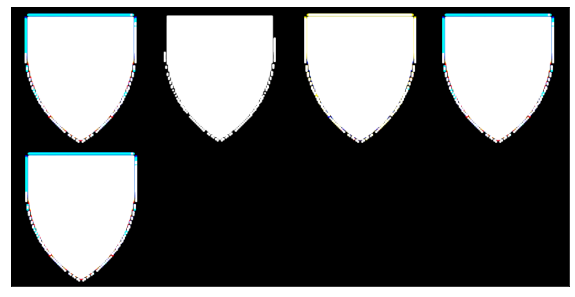

In [39]:
# Visualize one training batch
for images,classes,_,_,_ in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


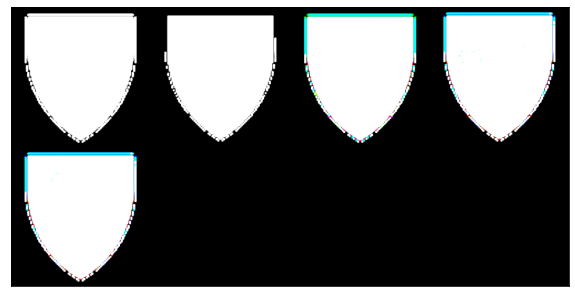

In [41]:
# Visualize one validation batch
for images,classes,_,_,_ in val_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

# Model Definition

In [42]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


In [43]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)


# Model Training, Validation and Testing

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 20


In [45]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)


In [46]:
### Training Code
from tqdm import tqdm

for epoch in range(epochs):
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    with tqdm(train_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch: 
            images = images.to(device)
            labels = labels.to(device)

            #Reset Grads
            optimizer.zero_grad()

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss & Backward, Update Weights (Step)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            #Append loss & acc
            loss_value = loss.item()
            train_epoch_loss.append(loss_value)
            train_epoch_accuracy.append(acc)
            
            tepoch.set_postfix({'train_epoch_loss': loss_value})
#             tepoch.set_postfix({'train_epoch_accuracy',acc})

            if _iter % 500 == 0:
                print("> Iteration {} < ".format(_iter))
                print("Iter Loss = {}".format(round(loss_value, 4)))
                print("Iter Accuracy = {} % \n".format(acc))

#             _iter += 1

    #Validation
    with tqdm(val_data_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for images, labels,_,_,_ in tepoch:
            images = images.to(device)
            labels = labels.to(device)

            #Forward ->
            preds = model(images)

            #Calculate Accuracy
            acc = calc_accuracy(labels.cpu(), preds.cpu())

            #Calculate Loss
            loss = criterion(preds, labels)

            #Append loss & acc
            loss_value = loss.item()
            val_epoch_loss.append(loss_value)
            val_epoch_accuracy.append(acc)
            tepoch.set_postfix({'val_epoch_loss': loss_value})
#             tepoch.set_postfix({'val_epoch_accuracy',acc})

    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))
    
    


Epoch 0: 100%|████████| 29/29 [00:03<00:00,  8.47batch/s, val_epoch_loss=4.62]


** Epoch 0 ** - Epoch Time 22
Train Loss = 4.7422
Train Accuracy = 3.218390804597701 % 

Val Loss = 4.3127
Val Accuracy = 1.3793103448275863 % 



Epoch 1: 100%|████████| 29/29 [00:02<00:00, 13.68batch/s, val_epoch_loss=3.78]


** Epoch 1 ** - Epoch Time 14
Train Loss = 3.6158
Train Accuracy = 12.183908045977011 % 

Val Loss = 3.5821
Val Accuracy = 8.275862068965518 % 



Epoch 2: 100%|████████| 29/29 [00:02<00:00, 13.84batch/s, val_epoch_loss=2.44]


** Epoch 2 ** - Epoch Time 14
Train Loss = 3.0168
Train Accuracy = 15.862068965517242 % 

Val Loss = 2.7629
Val Accuracy = 16.20689655172414 % 



Epoch 3: 100%|████████| 29/29 [00:02<00:00, 13.46batch/s, val_epoch_loss=2.58]


** Epoch 3 ** - Epoch Time 14
Train Loss = 2.3483
Train Accuracy = 28.620689655172413 % 

Val Loss = 2.2352
Val Accuracy = 33.96551724137931 % 



Epoch 4: 100%|████████| 29/29 [00:02<00:00, 14.30batch/s, val_epoch_loss=2.84]


** Epoch 4 ** - Epoch Time 14
Train Loss = 1.7608
Train Accuracy = 40.57471264367816 % 

Val Loss = 2.0273
Val Accuracy = 40.689655172413794 % 



Epoch 5: 100%|███████| 29/29 [00:02<00:00, 12.85batch/s, val_epoch_loss=0.645]


** Epoch 5 ** - Epoch Time 14
Train Loss = 1.7489
Train Accuracy = 42.52873563218391 % 

Val Loss = 1.4395
Val Accuracy = 52.41379310344828 % 



Epoch 6: 100%|███████| 29/29 [00:02<00:00, 14.26batch/s, val_epoch_loss=0.609]


** Epoch 6 ** - Epoch Time 14
Train Loss = 1.2909
Train Accuracy = 53.44827586206897 % 

Val Loss = 1.7097
Val Accuracy = 51.55172413793103 % 



Epoch 7: 100%|███████| 29/29 [00:02<00:00, 13.92batch/s, val_epoch_loss=0.208]


** Epoch 7 ** - Epoch Time 14
Train Loss = 1.1308
Train Accuracy = 58.39080459770115 % 

Val Loss = 1.0079
Val Accuracy = 67.58620689655173 % 



Epoch 8: 100%|███████| 29/29 [00:02<00:00, 14.47batch/s, val_epoch_loss=0.643]


** Epoch 8 ** - Epoch Time 14
Train Loss = 1.0287
Train Accuracy = 65.05747126436782 % 

Val Loss = 0.7672
Val Accuracy = 70.17241379310344 % 



Epoch 9: 100%|████████| 29/29 [00:02<00:00, 13.57batch/s, val_epoch_loss=0.65]


** Epoch 9 ** - Epoch Time 14
Train Loss = 0.8828
Train Accuracy = 71.95402298850574 % 

Val Loss = 0.9248
Val Accuracy = 70.86206896551724 % 



Epoch 10: 100%|█████| 29/29 [00:02<00:00, 14.11batch/s, val_epoch_loss=0.0621]


** Epoch 10 ** - Epoch Time 14
Train Loss = 0.7505
Train Accuracy = 72.64367816091954 % 

Val Loss = 0.7289
Val Accuracy = 80.0 % 



Epoch 11: 100%|██████| 29/29 [00:02<00:00, 14.32batch/s, val_epoch_loss=0.158]


** Epoch 11 ** - Epoch Time 13
Train Loss = 0.5652
Train Accuracy = 80.11494252873563 % 

Val Loss = 0.4679
Val Accuracy = 84.82758620689656 % 



Epoch 12: 100%|██████| 29/29 [00:02<00:00, 14.14batch/s, val_epoch_loss=0.415]


** Epoch 12 ** - Epoch Time 14
Train Loss = 0.4654
Train Accuracy = 83.67816091954023 % 

Val Loss = 0.5259
Val Accuracy = 86.03448275862068 % 



Epoch 13: 100%|█████| 29/29 [00:02<00:00, 13.63batch/s, val_epoch_loss=0.0116]


** Epoch 13 ** - Epoch Time 14
Train Loss = 0.2971
Train Accuracy = 88.96551724137932 % 

Val Loss = 0.521
Val Accuracy = 83.44827586206897 % 



Epoch 14: 100%|██████| 29/29 [00:02<00:00, 14.40batch/s, val_epoch_loss=0.119]


** Epoch 14 ** - Epoch Time 14
Train Loss = 0.2855
Train Accuracy = 88.96551724137932 % 

Val Loss = 0.373
Val Accuracy = 84.82758620689656 % 



Epoch 15: 100%|██████| 29/29 [00:02<00:00, 13.95batch/s, val_epoch_loss=0.132]


** Epoch 15 ** - Epoch Time 13
Train Loss = 0.2787
Train Accuracy = 87.1264367816092 % 

Val Loss = 0.4621
Val Accuracy = 82.75862068965517 % 



Epoch 16: 100%|█████| 29/29 [00:01<00:00, 14.59batch/s, val_epoch_loss=0.0835]


** Epoch 16 ** - Epoch Time 14
Train Loss = 0.2451
Train Accuracy = 90.11494252873563 % 

Val Loss = 0.2983
Val Accuracy = 88.96551724137932 % 



Epoch 17: 100%|████| 29/29 [00:02<00:00, 13.43batch/s, val_epoch_loss=3.42e-5]


** Epoch 17 ** - Epoch Time 14
Train Loss = 0.1826
Train Accuracy = 91.26436781609195 % 

Val Loss = 0.232
Val Accuracy = 90.34482758620689 % 



Epoch 18: 100%|████| 29/29 [00:02<00:00, 13.94batch/s, val_epoch_loss=0.00059]


** Epoch 18 ** - Epoch Time 14
Train Loss = 0.1813
Train Accuracy = 89.65517241379311 % 

Val Loss = 0.2012
Val Accuracy = 92.41379310344827 % 



Epoch 19: 100%|█████| 29/29 [00:02<00:00, 13.65batch/s, val_epoch_loss=0.0257]

** Epoch 19 ** - Epoch Time 14
Train Loss = 0.1831
Train Accuracy = 89.42528735632185 % 

Val Loss = 0.2498
Val Accuracy = 91.72413793103448 % 



In [47]:

from datetime import datetime

# save the latest model
now = datetime.now() # current date and time
timestr = now.strftime("%m-%d-%Y-%H:%M:%S")
model_full_path = f"{data_location}/classification-model-{timestr}.pth"

model.cpu()
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_epoch_loss,
    'accuracy': train_epoch_accuracy
}

torch.save(model_state, model_full_path)


In [56]:
model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
# test model 

test_epoch_loss = []
test_epoch_accuracy = []

test_loss = []
test_accuracy = []

# model.eval()
with torch.no_grad():
    for images, labels,_,_,_ in test_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        #Forward ->
        preds = model(images)

        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())

        #Calculate Loss
        loss = criterion(preds, labels)

        #Append loss & acc
        loss_value = loss.item()
        test_epoch_loss.append(loss_value)
        test_epoch_accuracy.append(acc)
        
test_epoch_loss = np.mean(test_epoch_loss)
test_epoch_accuracy = np.mean(test_epoch_accuracy)

test_loss.append(test_epoch_loss)
test_accuracy.append(test_epoch_accuracy)

print("Test Loss = {}".format(round(test_epoch_loss, 4)))
print("Test Accuracy = {} % \n".format(test_epoch_accuracy))


Test Loss = 0.5198
Test Accuracy = 82.06896551724138 % 

